In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\Online_Courses.csv")

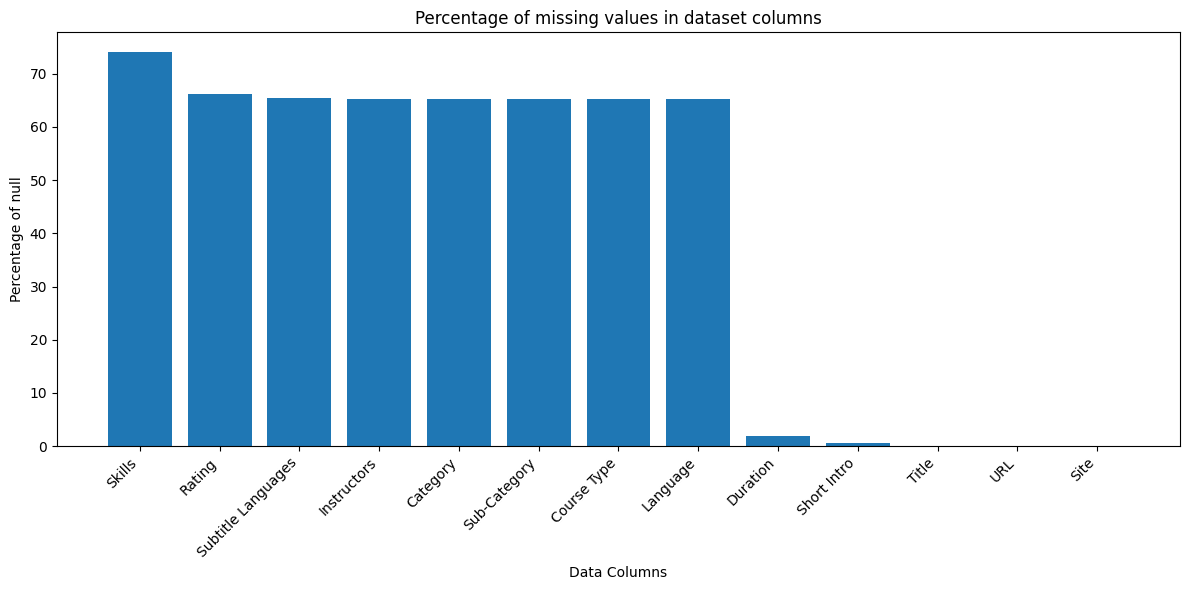

In [ ]:
columns_to_plot = [
    "Title", "URL", "Short Intro", "Category", "Sub-Category",
    "Course Type", "Language", "Subtitle Languages", "Skills",
    "Instructors", "Rating", "Number of Viewers", "Duration", "Site"
]

existing_columns = [col for col in columns_to_plot if col in df.columns]

null_perc = df[existing_columns].isnull().mean() * 100

null_perc = null_perc.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(null_perc.index, null_perc.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Data Columns')
plt.ylabel('Percentage of null')
plt.title('Percentage of missing values in dataset columns')
plt.tight_layout()
plt.show()

In [8]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


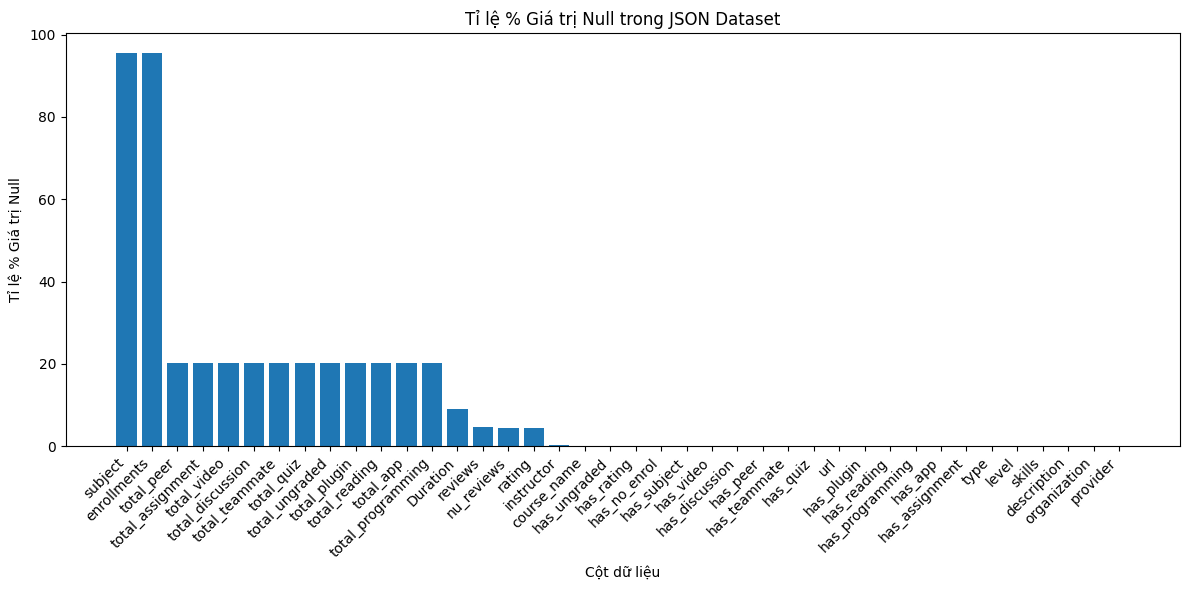

In [ ]:
import json
with open('D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\combined_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(data)

df.replace("NaN", pd.NA, inplace=True)

summary = pd.DataFrame({
    'column': df.columns,
    'null_percentage': df.isnull().mean().values * 100
}).sort_values(by='null_percentage', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(summary['column'], summary['null_percentage'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Cột dữ liệu')
plt.ylabel('Tỉ lệ % Giá trị Null')
plt.title('Tỉ lệ % Giá trị Null trong JSON Dataset')
plt.tight_layout()
plt.show()

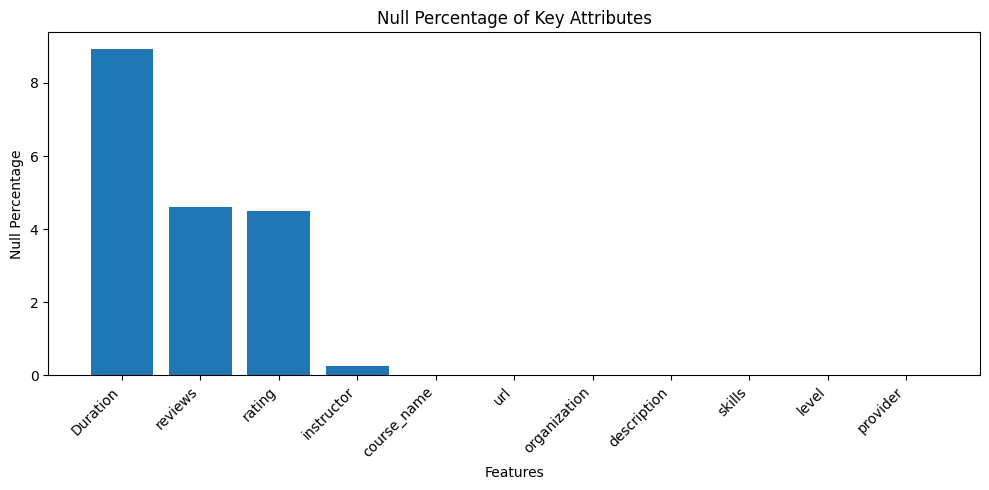

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open('D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\combined_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(data)

df.replace("NaN", pd.NA, inplace=True)

columns_to_plot = [
    "url",
    "course_name",
    "organization",
    "instructor",
    "rating",
    "description",
    "skills",
    "level",
    "Duration",
    "reviews",
    "provider"
]

existing_cols = [col for col in columns_to_plot if col in df.columns]

null_perc = df[existing_cols].isnull().mean() * 100
null_perc = null_perc.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(null_perc.index, null_perc.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Null Percentage')
plt.title('Null Percentage of Key Attributes')
plt.tight_layout()
plt.show()


In [7]:
pip install undetected-chromedriver


Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47130 sha256=e8060ac0927062b5e653ecaef95641c06efc755b28ba7f678e2a2bdabd467acc
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\c4\f1\aa\9de6cf276210554d91e9c0526864563e850a428c5e76da4914
Successfully built undetected-chromedriver



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
import pandas as pd

with open('D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\combined_dataset.json', 
          'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(data)

total_courses = len(df)
print(f"Total courses: {total_courses}")

total_attributes = df.shape[1]
print(f"Total attributes per course: {total_attributes}")

duplicate_mask = df.duplicated(subset=['url'], keep=False)
duplicate_count = duplicate_mask.sum()
print(f"Duplicate courses (by URL): {duplicate_count}")

duplicates = df[duplicate_mask].sort_values('url')
print("\nDuplicate entries:")
print(duplicates[['url', 'course_name']])


Total courses: 13793
Total attributes per course: 40
Duplicate courses (by URL): 0

Duplicate entries:
Empty DataFrame
Columns: [url, course_name]
Index: []


In [ ]:
from sklearn.metrics import accuracy_score
import logging
import sys
import ollama
import numpy as np
import json
import re
import streamlit as st
from neo4j import GraphDatabase
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import time
from typing import List, Dict, Any

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s:%(name)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

class QueryProcessor:
    def __init__(self, model_name: str = "qwen2.5-coder:3b"):
        self.model_name = model_name
        self.json_pattern = re.compile(r'\{.*\}', re.DOTALL | re.MULTILINE)

    def generate_query_plan(self, user_query: str) -> Dict:
        start_time = time.perf_counter()
        prompt = f"""
        You are a Neo4j Cypher expert. Generate a valid Cypher query following these STRICT RULES:
        
        MANDATORY RULES:
        1. Query MUST start with MATCH
        2. Use ONLY these node labels: Course, Skill, Level, Organization, Instructor, Career
        3. Use ONLY these relationships: TEACHES, HAS_LEVEL, OFFERED_BY, TAUGHT_BY, REQUIRES
        4. ALWAYS use single quotes for string values: 'value'
        5. Combine conditions using WHERE clause when needed
        6. MUST include RETURN clause with course properties
        7. The value of final_query MUST begin with the keyword MATCH (case insensitive)
        8. NEVER use double quotes "" inside the Cypher
        9. Special rule for levels:
            - Detect any of these keywords in the query (case-insensitive):
                Beginner, Introductory, Basics, Fundamentals...
                Intermediate, Mid-level... 
                Advanced, Expert, Hard... 
            - Map the matched keyword to Level.name exactly (“Beginner”, “Intermediate” or “Advanced”).
            - Remove that keyword (and any prepositions like “of”) from the skill phrase.
            - **Normalize the skill name** by converting it to Title Case (capitalize the first letter of each word).
            - Then generate one step to MATCH the Skill{{name: $skill_name}} and one step to MATCH courses with HAS_LEVEL → Level{{name: $level}}.
        10. For ANY of these Course→X relationships (TEACHES, HAS_LEVEL, OFFERED_BY, TAUGHT_BY), always match directly from 'Course':
            MATCH (c:Course)-[:REL_TYPE]->(x:NodeType {{…}}),
            do not write (c)-[:TEACHES]->(s)-[:HAS_LEVEL]->(l).

        11. NEVER put relationship patterns inside WHERE. 
            Always include Course→X relationships in a MATCH clause 
            or comma-separated in the first MATCH.
        12. Rating is in string format, if any query about rating, change to toFloat(c.rating) instead of c.rating for the whole Cypher.
        SCHEMA:
        - Course properties: url, name, duration, rating, description
        - Relationships directions: 
          (Course)-[:TEACHES]->(Skill)
          (Course)-[:HAS_LEVEL]->(Level)
          (Course)-[:OFFERED_BY]->(Organization)
          (Course)-[:TAUGHT_BY]->(Instructor)
          (Career)-[:REQUIRES]->(Skill)

        EXAMPLES:[
        {{
                "natural_query": "Find courses about machine learning",
                "steps": ["Match courses teaching Machine Learning skill", "Return results"],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Machine Learning'}}) RETURN c.name, c.url, c.rating"
            }},

        {{
                "natural_query": "Advanced Cybersecurity courses from Google",
                "steps": [
                    "Find Cybersecurity skill courses",
                    "Filter by Advanced level",
                    "Check offered by Google",
                    "Return results"
                ],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Cybersecurity'}}), (c)-[:HAS_LEVEL]->(l:Level {{name: 'Advanced'}}), (c)-[:OFFERED_BY]->(o:Organization {{name: 'Google'}}) RETURN c.name, c.url, c.duration"
            }},
        {{  
                "natural_query": Find me some Python beginner courses
                "steps": ["Find Python skill courses", "Filter by Beginner level"],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Python'}}), (c)-[:HAS_LEVEL]->(l:Level {{name: 'Beginner'}}) RETURN c.name, c.url, c.duration"
            }},
        {{
                "natural_query": "Data science courses with rating > 4.5",
                "steps": [
                    "Match courses teaching Data Science skill",
                    "Filter by courses with rating greater than 4.5",
                    "Return results"
                ],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Data Science'}}) WHERE toFloat(c.rating) > 4.5 RETURN c.name, c.url, c.rating"
        }}
        ]
        USER QUERY: {user_query}

        OUTPUT FORMAT (JSON):
        {{
            "steps": ["step1", "step2", ...],
            "final_query": "MATCH...RETURN..."
        }}
        """
        
        try:
            logger.debug(f"Generating query plan with prompt:\n{prompt[:500]}...")
            response = ollama.generate(
                model=self.model_name,
                prompt=prompt,
                options={'temperature': 0.1},
                format='json'
            )
            gen_time = time.perf_counter() - start_time
            logger.info(f"Query generated in {gen_time:.2f}s")
            
            
            plan = self.extract_json(response['response'])
            plan['final_query'] = self.clean_cypher(plan['final_query'])
            self.validate_cypher(plan['final_query'])
            plan['debug_info'] = {
                'gen_time': gen_time,
                'model': self.model_name,
                'prompt_tokens': len(prompt.split()),
                'response_tokens': len(response['response'].split())
            }
            return plan
            
        except Exception as e:
            gen_time = time.perf_counter() - start_time
            logger.error(f"Query generation failed after {gen_time:.2f}s: {str(e)}")
            return {
                "steps": ["Error generating query plan"],
                "final_query": "",
                "debug_info": {
                    'error': str(e),
                    'gen_time': gen_time
                }
            }
    def validate_cypher(self, query: str):
        """Enhanced Cypher validation"""
        # Check for empty query
        if not query:
            raise ValueError("Empty query")
            
        q = re.sub(r"^```cypher|```$", "", query.strip(), flags=re.IGNORECASE).strip()
        if not re.match(r'(?i)^MATCH\s', q):
            raise ValueError("Query must start with MATCH clause")
            
        # Check contains RETURN clause
        if "RETURN" not in query.upper():
            raise ValueError("Query missing RETURN clause")
            
        # Check for forbidden keywords
        forbidden = ["CREATE", "DELETE", "SET", "REMOVE", "MERGE"]
        for word in forbidden:
            if word in query.upper():
                raise ValueError(f"Forbidden keyword detected: {word}")


    def extract_json(self, text: str) -> Dict:
        # Preprocessing steps
        text = text.replace("True", "true").replace("False", "false")
        text = re.sub(r'/\*.*?\*/', '', text, flags=re.DOTALL)
        
        # Find JSON candidate block
        match = self.json_pattern.search(text)
        if not match:
            raise ValueError("No JSON found in response")
        json_str = match.group()
        
        # Special handling for final_query string values
        def replace_inner_quotes(m):
            inner = m.group(1)
            # Replace all unescaped double quotes with single quotes
            inner = re.sub(r'(?<!\\)"', "'", inner)
            # Escape any remaining backslashes
            inner = inner.replace('\\', '\\\\')
            return f'"final_query": "{inner}"'
        
        # Process final_query field
        json_str = re.sub(
            r'"final_query"\s*:\s*"((?:\\"|[^"])*)"',
            replace_inner_quotes,
            json_str,
            flags=re.DOTALL
        )
        
        # Convert smart quotes to regular quotes
        json_str = json_str.replace('“', '"').replace('”', '"')
        
        # Handle missing commas in JSON arrays
        json_str = re.sub(r'\s*]\s*{', '], {', json_str)
        
        try:
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            logger.error(f"JSON decode error: {e.msg}")
            logger.error(f"Problematic JSON content: {json_str}")
            raise


    
    def clean_cypher(self, query: str) -> str:
        # 1) Strip markdown fences & semicolons
        q = query.strip()
        q = re.sub(r"^```cypher|```$", "", q, flags=re.IGNORECASE).strip()
        q = re.sub(r";+\s*$", "", q)

        # 2) Force single quotes around properties
        #    e.g. replace name: "Python" → name: 'Python'
        q = re.sub(r'name:\s*"([^"]+)"', r"name: '\1'", q)

        # 3) Correct any chained Skill→Level patterns to separate MATCHes
        #    If it sees (s:Skill)…-[:HAS_LEVEL]->(l:Level), fix it:
        q = re.sub(
            r'\(c:Course\)-\[:TEACHES\]->\(s:Skill\s*\{[^\}]+\}\)-\[:HAS_LEVEL\]->\(l:Level\s*\{[^\}]+\}\)',
            "(c:Course)-[:TEACHES]->(s:Skill {name: 'Python'}), (c)-[:HAS_LEVEL]->(l:Level {name: 'Beginner'})",
            q
        )

        # 4) Normalize whitespace and return
        q = re.sub(r'\s+', ' ', q).strip()
        return q

class CypherEvaluator:
    def __init__(self, test_data_path: str, neo4j_config: dict, processor: QueryProcessor):
        self.test_data = self.load_test_data(test_data_path)
        self.processor = processor
        self.driver = GraphDatabase.driver(**neo4j_config)
        self.results: List[Dict[str, Any]] = []

        # Counters and accumulators
        self.total = 0
        self.exact_matches = 0
        self.errors = 0
        self.times: List[float] = []
        self.precisions: List[float] = []
        self.recalls: List[float] = []

    def load_test_data(self, path: str) -> List[Dict]:
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            for item in data:
                assert all(k in item for k in ("query_id","natural_language_query","cypher_query"))
            return data
        except Exception as e:
            logger.error(f"Error loading test data: {e}")
            return []

    def execute_cypher(self, query: str) -> List[Any]:
        try:
            with self.driver.session() as session:
                result = session.run(query)
                rows = []
                for rec in result:
                    v = rec.values()[0]
                    rows.append(dict(v.items()) if hasattr(v, 'items') else v)
                return sorted(rows, key=lambda x: str(x))
        except Exception as e:
            logger.error(f"Execution error: {e}")
            return None

    def generate_query(self, natural_query: str) -> Dict[str, Any]:
        try:
            plan = self.processor.generate_query_plan(natural_query)
            q = plan.get("final_query","")
            status = "generation_success" if q else "generation_failed"
            return {"query": q, "status": status}
        except Exception as e:
            logger.error(f"Generation error: {e}")
            return {"query": "", "status": "generation_error"}

    def run_evaluation(self):
        logger.info(f"Starting evaluation with model `{self.processor.model_name}` on {len(self.test_data)} cases...")
        self.total = len(self.test_data)

        for case in self.test_data:
            start = time.time()
            query_id = case["query_id"]

            # 1) Generate
            gen = self.generate_query(case["natural_language_query"])
            if gen["status"] != "generation_success":
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": gen["status"],
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 2) Execute generated
            gen_res = self.execute_cypher(gen["query"])
            if gen_res is None:
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": "execution_failed",
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 3) Execute expected
            exp_res = self.execute_cypher(case["cypher_query"])
            if exp_res is None:
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": "expected_execution_failed",
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 4) Compare sets
            set_gen = set(json.dumps(r, sort_keys=True) for r in gen_res)
            set_exp = set(json.dumps(r, sort_keys=True) for r in exp_res)
            tp = len(set_gen & set_exp)
            precision = tp / len(set_gen) if set_gen else 0.0
            recall    = tp / len(set_exp) if set_exp else 0.0

            exact = (set_gen == set_exp)
            if exact:
                self.exact_matches += 1

            elapsed = time.time() - start
            self.times.append(elapsed)
            self.precisions.append(precision)
            self.recalls.append(recall)

            self.results.append({
                "query_id": query_id,
                "status": "match" if exact else "partial_match",
                "precision": precision,
                "recall":    recall,
                "exact_match": exact,
                "time_s":    elapsed
            })

        logger.info("Evaluation completed.")

    def calculate_final_metrics(self) -> Dict[str, Any]:
        avg_time = sum(self.times) / len(self.times) if self.times else 0.0
        accuracy = self.exact_matches / self.total if self.total else 0.0
        avg_precision = sum(self.precisions) / len(self.precisions) if self.precisions else 0.0
        avg_recall    = sum(self.recalls)    / len(self.recalls)    if self.recalls    else 0.0
        avg_f1 = (2 * avg_precision * avg_recall / (avg_precision + avg_recall)
                  if (avg_precision + avg_recall) else 0.0)

        return {
            "model_name":         self.processor.model_name,
            "total_cases":        self.total,
            "exact_match_count":  self.exact_matches,
            "error_count":        self.errors,
            "accuracy":           accuracy,
            "average_precision":  avg_precision,
            "average_recall":     avg_recall,
            "average_f1":         avg_f1,
            "average_time_s":     avg_time
        }

    def save_results(self, output_path: str):
        out = {
            "cases":   self.results,
            "metrics": self.calculate_final_metrics()
        }
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(out, f, indent=2, ensure_ascii=False)
        logger.info(f"Results saved to {output_path}")

if __name__ == "__main__":
    TEST_JSON   = "D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\test40_queries.json"
    NEO4J_CONF  = {"uri": "bolt://localhost:7687", "auth": ("neo4j","12345678")}
    OUTPUT_DIR  = "D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\"

    model_list = [
        "qwen2.5-coder:3b",
        "llama3.2:3b",
        "qwen2.5:3b",
        "deepseek-r1:7b",
        "qwen3:4b"
    ]

    for model_name in model_list:
        processor = QueryProcessor(model_name=model_name)
        evaluator = CypherEvaluator(TEST_JSON, NEO4J_CONF, processor)

        evaluator.run_evaluation()
        out_path = f"{OUTPUT_DIR}evaluation_results_fix_{model_name.replace(':','_')}.json"
        evaluator.save_results(out_path)

        metrics = evaluator.calculate_final_metrics()
        print(f"\n=== Metrics for {model_name} ===")
        for k, v in metrics.items():
            print(f"{k}: {v}")


2025-05-27 12:46:00,557 INFO:__main__: Starting evaluation with model `qwen2.5-coder:3b` on 50 cases...


<>:396: SyntaxWarning: invalid escape sequence '\C'
<>:396: SyntaxWarning: invalid escape sequence '\C'
C:\Users\admin\AppData\Local\Temp\ipykernel_5128\3657757984.py:396: SyntaxWarning: invalid escape sequence '\C'
  OUTPUT_DIR  = "D:\\Thesis\Courses-Searching\\course_searching_main\\data\\"


2025-05-27 12:47:08,179 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-27 12:47:08,186 INFO:__main__: Query generated in 67.63s
2025-05-27 12:47:18,877 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-27 12:47:18,881 INFO:__main__: Query generated in 7.41s
2025-05-27 12:47:27,891 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-27 12:47:27,892 INFO:__main__: Query generated in 8.43s
2025-05-27 12:47:37,345 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-27 12:47:37,346 INFO:__main__: Query generated in 8.95s
2025-05-27 12:47:46,789 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-27 12:47:46,791 INFO:__main__: Query generated in 8.45s
2025-05-27 12:47:55,267 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-27 12:47:55,269 I

In [1]:
from sklearn.metrics import accuracy_score
import logging
import sys
import ollama
import numpy as np
import json
import re
import streamlit as st
from neo4j import GraphDatabase
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import time
from typing import List, Dict, Any

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s:%(name)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

class QueryProcessor:
    def __init__(self, model_name: str = "qwen3:1.7b"):
        self.model_name = model_name
        self.json_pattern = re.compile(r'\{.*\}', re.DOTALL | re.MULTILINE)

    def generate_query_plan(self, user_query: str) -> Dict:
        start_time = time.perf_counter()
        prompt = f"""
        You are a Neo4j Cypher expert. Generate a valid Cypher query following these STRICT RULES:
        
        MANDATORY RULES:
        1. Query MUST start with MATCH
        2. Use ONLY these node labels: Course, Skill, Level, Organization, Instructor, Career
        3. Use ONLY these relationships: TEACHES, HAS_LEVEL, OFFERED_BY, TAUGHT_BY, REQUIRES
        4. ALWAYS use single quotes for string values: 'value'
        5. Combine conditions using WHERE clause when needed
        6. MUST include RETURN clause with course properties
        7. The value of final_query MUST begin with the keyword MATCH (case insensitive)
        8. NEVER use double quotes "" inside the Cypher
        9. Special rule for levels:
            - Detect any of these keywords in the query (case-insensitive):
                Beginner, Introductory, Basics, Fundamentals...
                Intermediate, Mid-level... 
                Advanced, Expert, Hard... 
            - Map the matched keyword to Level.name exactly (“Beginner”, “Intermediate” or “Advanced”).
            - Remove that keyword (and any prepositions like “of”) from the skill phrase.
            - **Normalize the skill name** by converting it to Title Case (capitalize the first letter of each word).
            - Then generate one step to MATCH the Skill{{name: $skill_name}} and one step to MATCH courses with HAS_LEVEL → Level{{name: $level}}.
        10. For ANY of these Course→X relationships (TEACHES, HAS_LEVEL, OFFERED_BY, TAUGHT_BY), always match directly from 'Course':
            MATCH (c:Course)-[:REL_TYPE]->(x:NodeType {{…}}),
            do not write (c)-[:TEACHES]->(s)-[:HAS_LEVEL]->(l).

        11. NEVER put relationship patterns inside WHERE. 
            Always include Course→X relationships in a MATCH clause 
            or comma-separated in the first MATCH.
        12. Rating is in string format, if any query about rating, change to toFloat(c.rating) instead of c.rating for the whole Cypher.
        SCHEMA:
        - Course properties: url, name, duration, rating, description
        - Relationships directions: 
          (Course)-[:TEACHES]->(Skill)
          (Course)-[:HAS_LEVEL]->(Level)
          (Course)-[:OFFERED_BY]->(Organization)
          (Course)-[:TAUGHT_BY]->(Instructor)
          (Career)-[:REQUIRES]->(Skill)

        EXAMPLES:[
        {{
                "natural_query": "Find courses about machine learning",
                "steps": ["Match courses teaching Machine Learning skill", "Return results"],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Machine Learning'}}) RETURN c.name, c.url, c.rating"
            }},

        {{
                "natural_query": "Advanced Cybersecurity courses from Google",
                "steps": [
                    "Find Cybersecurity skill courses",
                    "Filter by Advanced level",
                    "Check offered by Google",
                    "Return results"
                ],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Cybersecurity'}}), (c)-[:HAS_LEVEL]->(l:Level {{name: 'Advanced'}}), (c)-[:OFFERED_BY]->(o:Organization {{name: 'Google'}}) RETURN c.name, c.url, c.duration"
            }},
        {{  
                "natural_query": Find me some Python beginner courses
                "steps": ["Find Python skill courses", "Filter by Beginner level"],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Python'}}), (c)-[:HAS_LEVEL]->(l:Level {{name: 'Beginner'}}) RETURN c.name, c.url, c.duration"
            }},
        {{
                "natural_query": "Data science courses with rating > 4.5",
                "steps": [
                    "Match courses teaching Data Science skill",
                    "Filter by courses with rating greater than 4.5",
                    "Return results"
                ],
                "final_query": "MATCH (c:Course)-[:TEACHES]->(s:Skill {{name: 'Data Science'}}) WHERE toFloat(c.rating) > 4.5 RETURN c.name, c.url, c.rating"
        }}
        ]
        USER QUERY: {user_query}

        OUTPUT FORMAT (JSON):
        {{
            "steps": ["step1", "step2", ...],
            "final_query": "MATCH...RETURN..."
        }}
        """
        
        try:
            logger.debug(f"Generating query plan with prompt:\n{prompt[:500]}...")
            response = ollama.generate(
                model=self.model_name,
                prompt=prompt,
                options={'temperature': 0.1},
                format='json'
            )
            gen_time = time.perf_counter() - start_time
            logger.info(f"Query generated in {gen_time:.2f}s")
            
            
            plan = self.extract_json(response['response'])
            plan['final_query'] = self.clean_cypher(plan['final_query'])
            self.validate_cypher(plan['final_query'])
            plan['debug_info'] = {
                'gen_time': gen_time,
                'model': self.model_name,
                'prompt_tokens': len(prompt.split()),
                'response_tokens': len(response['response'].split())
            }
            return plan
            
        except Exception as e:
            gen_time = time.perf_counter() - start_time
            logger.error(f"Query generation failed after {gen_time:.2f}s: {str(e)}")
            return {
                "steps": ["Error generating query plan"],
                "final_query": "",
                "debug_info": {
                    'error': str(e),
                    'gen_time': gen_time
                }
            }
    def validate_cypher(self, query: str):
        """Enhanced Cypher validation"""
        # Check for empty query
        if not query:
            raise ValueError("Empty query")
            
        q = re.sub(r"^```cypher|```$", "", query.strip(), flags=re.IGNORECASE).strip()
        if not re.match(r'(?i)^MATCH\s', q):
            raise ValueError("Query must start with MATCH clause")
            
        # Check contains RETURN clause
        if "RETURN" not in query.upper():
            raise ValueError("Query missing RETURN clause")
            
        # Check for forbidden keywords
        forbidden = ["CREATE", "DELETE", "SET", "REMOVE", "MERGE"]
        for word in forbidden:
            if word in query.upper():
                raise ValueError(f"Forbidden keyword detected: {word}")


    def extract_json(self, text: str) -> Dict:
        # Preprocessing steps
        text = text.replace("True", "true").replace("False", "false")
        text = re.sub(r'/\*.*?\*/', '', text, flags=re.DOTALL)
        
        # Find JSON candidate block
        match = self.json_pattern.search(text)
        if not match:
            raise ValueError("No JSON found in response")
        json_str = match.group()
        
        # Special handling for final_query string values
        def replace_inner_quotes(m):
            inner = m.group(1)
            # Replace all unescaped double quotes with single quotes
            inner = re.sub(r'(?<!\\)"', "'", inner)
            # Escape any remaining backslashes
            inner = inner.replace('\\', '\\\\')
            return f'"final_query": "{inner}"'
        
        # Process final_query field
        json_str = re.sub(
            r'"final_query"\s*:\s*"((?:\\"|[^"])*)"',
            replace_inner_quotes,
            json_str,
            flags=re.DOTALL
        )
        
        # Convert smart quotes to regular quotes
        json_str = json_str.replace('“', '"').replace('”', '"')
        
        # Handle missing commas in JSON arrays
        json_str = re.sub(r'\s*]\s*{', '], {', json_str)
        
        try:
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            logger.error(f"JSON decode error: {e.msg}")
            logger.error(f"Problematic JSON content: {json_str}")
            raise


    
    def clean_cypher(self, query: str) -> str:
        # 1) Strip markdown fences & semicolons
        q = query.strip()
        q = re.sub(r"^```cypher|```$", "", q, flags=re.IGNORECASE).strip()
        q = re.sub(r";+\s*$", "", q)

        # 2) Force single quotes around properties
        #    e.g. replace name: "Python" → name: 'Python'
        q = re.sub(r'name:\s*"([^"]+)"', r"name: '\1'", q)

        # 3) Correct any chained Skill→Level patterns to separate MATCHes
        #    If it sees (s:Skill)…-[:HAS_LEVEL]->(l:Level), fix it:
        q = re.sub(
            r'\(c:Course\)-\[:TEACHES\]->\(s:Skill\s*\{[^\}]+\}\)-\[:HAS_LEVEL\]->\(l:Level\s*\{[^\}]+\}\)',
            "(c:Course)-[:TEACHES]->(s:Skill {name: 'Python'}), (c)-[:HAS_LEVEL]->(l:Level {name: 'Beginner'})",
            q
        )

        # 4) Normalize whitespace and return
        q = re.sub(r'\s+', ' ', q).strip()
        return q

class CypherEvaluator:
    def __init__(self, test_data_path: str, neo4j_config: dict, processor: QueryProcessor):
        self.test_data = self.load_test_data(test_data_path)
        self.processor = processor
        self.driver = GraphDatabase.driver(**neo4j_config)
        self.results: List[Dict[str, Any]] = []

        # Counters and accumulators
        self.total = 0
        self.exact_matches = 0
        self.errors = 0
        self.times: List[float] = []
        self.precisions: List[float] = []
        self.recalls: List[float] = []

    def load_test_data(self, path: str) -> List[Dict]:
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            for item in data:
                assert all(k in item for k in ("query_id","natural_language_query","cypher_query"))
            return data
        except Exception as e:
            logger.error(f"Error loading test data: {e}")
            return []

    def execute_cypher(self, query: str) -> List[Any]:
        try:
            with self.driver.session() as session:
                result = session.run(query)
                rows = []
                for rec in result:
                    v = rec.values()[0]
                    rows.append(dict(v.items()) if hasattr(v, 'items') else v)
                return sorted(rows, key=lambda x: str(x))
        except Exception as e:
            logger.error(f"Execution error: {e}")
            return None

    def generate_query(self, natural_query: str) -> Dict[str, Any]:
        try:
            plan = self.processor.generate_query_plan(natural_query)
            q = plan.get("final_query","")
            status = "generation_success" if q else "generation_failed"
            return {"query": q, "status": status}
        except Exception as e:
            logger.error(f"Generation error: {e}")
            return {"query": "", "status": "generation_error"}

    def run_evaluation(self):
        logger.info(f"Starting evaluation with model `{self.processor.model_name}` on {len(self.test_data)} cases...")
        self.total = len(self.test_data)

        for case in self.test_data:
            start = time.time()
            query_id = case["query_id"]

            # 1) Generate
            gen = self.generate_query(case["natural_language_query"])
            if gen["status"] != "generation_success":
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": gen["status"],
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 2) Execute generated
            gen_res = self.execute_cypher(gen["query"])
            if gen_res is None:
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": "execution_failed",
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 3) Execute expected
            exp_res = self.execute_cypher(case["cypher_query"])
            if exp_res is None:
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": "expected_execution_failed",
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 4) Compare sets
            set_gen = set(json.dumps(r, sort_keys=True) for r in gen_res)
            set_exp = set(json.dumps(r, sort_keys=True) for r in exp_res)
            tp = len(set_gen & set_exp)
            precision = tp / len(set_gen) if set_gen else 0.0
            recall    = tp / len(set_exp) if set_exp else 0.0

            exact = (set_gen == set_exp)
            if exact:
                self.exact_matches += 1

            elapsed = time.time() - start
            self.times.append(elapsed)
            self.precisions.append(precision)
            self.recalls.append(recall)

            self.results.append({
                "query_id": query_id,
                "status": "match" if exact else "partial_match",
                "precision": precision,
                "recall":    recall,
                "exact_match": exact,
                "time_s":    elapsed
            })

        logger.info("Evaluation completed.")

    def calculate_final_metrics(self) -> Dict[str, Any]:
        avg_time = sum(self.times) / len(self.times) if self.times else 0.0
        accuracy = self.exact_matches / self.total if self.total else 0.0
        avg_precision = sum(self.precisions) / len(self.precisions) if self.precisions else 0.0
        avg_recall    = sum(self.recalls)    / len(self.recalls)    if self.recalls    else 0.0
        avg_f1 = (2 * avg_precision * avg_recall / (avg_precision + avg_recall)
                  if (avg_precision + avg_recall) else 0.0)

        return {
            "model_name":         self.processor.model_name,
            "total_cases":        self.total,
            "exact_match_count":  self.exact_matches,
            "error_count":        self.errors,
            "accuracy":           accuracy,
            "average_precision":  avg_precision,
            "average_recall":     avg_recall,
            "average_f1":         avg_f1,
            "average_time_s":     avg_time
        }

    def save_results(self, output_path: str):
        out = {
            "cases":   self.results,
            "metrics": self.calculate_final_metrics()
        }
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(out, f, indent=2, ensure_ascii=False)
        logger.info(f"Results saved to {output_path}")

if __name__ == "__main__":
    TEST_JSON   = "D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\test40_queries.json"
    NEO4J_CONF  = {"uri": "bolt://localhost:7687", "auth": ("neo4j","12345678")}
    OUTPUT_DIR  = "D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\"

    model_list = [
        #"qwen2.5-coder:3b",
        #"llama3.2:3b",
        #"qwen2.5:3b",
        #"deepseek-r1:7b",
        #"qwen3:4b",
        "qwen3:1.7b"
    ]

    for model_name in model_list:
        processor = QueryProcessor(model_name=model_name)
        evaluator = CypherEvaluator(TEST_JSON, NEO4J_CONF, processor)

        evaluator.run_evaluation()
        out_path = f"{OUTPUT_DIR}evaluation_results_fix_{model_name.replace(':','_')}.json"
        evaluator.save_results(out_path)

        metrics = evaluator.calculate_final_metrics()
        print(f"\n=== Metrics for {model_name} ===")
        for k, v in metrics.items():
            print(f"{k}: {v}")


2025-06-23 05:34:14,307 INFO:__main__: Starting evaluation with model `qwen3:1.7b` on 50 cases...
2025-06-23 05:35:02,059 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 05:35:02,066 INFO:__main__: Query generated in 47.75s
2025-06-23 05:35:13,953 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 05:35:13,954 INFO:__main__: Query generated in 8.84s
2025-06-23 05:35:26,070 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 05:35:26,071 INFO:__main__: Query generated in 11.80s
2025-06-23 05:35:32,322 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 05:35:32,324 INFO:__main__: Query generated in 5.98s
2025-06-23 05:35:41,501 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 05:35:41,503 INFO:__main__: Query generated in 8.79s
2025-06-23 05:35:47,903 INFO:httpx:

In [3]:
from sklearn.metrics import accuracy_score
import logging
import sys
import ollama
import numpy as np
import json
import re
import streamlit as st
from neo4j import GraphDatabase
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import time
from typing import List, Dict, Any

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s:%(name)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

class QueryProcessor:
    def __init__(self, model_name: str = "qwen3:1.7b"):
        self.model_name = model_name
        self.json_pattern = re.compile(r'\{.*\}', re.DOTALL | re.MULTILINE)

    def generate_query_plan(self, user_query: str, candidate_skills: list = None) -> Dict:
        start_time = time.perf_counter()
        
        # Tạo skills_str TRỰC TIẾP thay vì dùng cache key phức tạp
        skills_str = ""
        if candidate_skills:
            escaped = [s.replace("'", "\\'").replace('"', '\\"') for s in candidate_skills]
            quoted = [f"'{s}'" for s in escaped]
            joined = ",".join(quoted)
            skills_str = f"[{joined}]"

        prompt = f"""
    You are a Neo4j Cypher expert. Generate a valid Cypher query according to these STRICT RULES:

    **BASIC QUERY RULES:**
    1. Query MUST start with MATCH.
    2. Use ONLY node labels: Course, Instructor, Level, Organization, Provider, Review, Skill, Subject
    3. Use ONLY relationships: HAS_LEVEL, HAS_REVIEW, HAS_SUBJECT, OFFERED_BY, PROVIDED_BY, TAUGHT_BY, TEACHES
    4. ALWAYS use single quotes for string values: 'value'.
    5. NEVER use double quotes "" inside the Cypher.
    6. If rating is involved, use toFloat(c.rating) instead of c.rating.
    7. MUST include RETURN clause.
    8. final_query MUST begin with MATCH (case insensitive).
    9. **NEVER use multiple WHERE clauses in one query!**
        MATCH (c:Course)-[:TAUGHT_BY]->(i:Instructor), (c)-[:TEACHES]->(s:Skill)
        WHERE i.name = 'Name' AND s.name IN ['skill1']

    **MULTIPLE CONDITIONS RULE:**
    If there are multiple conditions (skill, level, provider, etc.), you MUST use ONE of these patterns:

    Option A - Single MATCH with comma-separated patterns:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:TAUGHT_BY]->(i:Instructor)
    WHERE s.name IN ['skill1', 'skill2']

    Option B - Multiple MATCH lines with one WHERE:
    MATCH (c:Course)-[:TEACHES]->(s:Skill)
    MATCH (c)-[:TAUGHT_BY]->(i:Instructor)  
    WHERE s.name IN ['skill1', 'skill2']

    NEVER use this INVALID syntax:
    ❌ MATCH (c:Course)-[:TEACHES]->(s:Skill) WHERE condition, (other)-[:REL]->(node)
    ✅ MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:TAUGHT_BY]->(i:Instructor) WHERE condition

    **LEVEL HANDLING RULE:**
    If user query implies a course level (e.g., "Beginner", "Intermediate", "Advanced"), you MUST:
    a. First try to match via the HAS_LEVEL relationship:
    MATCH (c:Course)-[:HAS_LEVEL]->(l:Level {{name: '<LevelName>'}})
    b. ONLY if no such Level node exists, fallback to checking the course title:
    c.name CONTAINS '<level keyword>'
    c. Special rule for levels:
    - Detect keywords: Beginner, Introductory, Basics, Fundamentals... → "Beginner"
    - Intermediate, Mid-level... → "Intermediate" 
    - Advanced, Expert, Hard... → "Advanced"
    - Map keyword to exact Level.name and normalize skill name to Title Case

    **SKILL FILTERING RULE:**
    When CANDIDATE_SKILLS is provided, you MUST use ALL relevant skills from the list in the WHERE clause:
    - Analyze user query to determine which skills are relevant
    - Include ALL relevant skills: s.name IN ['skill1', 'skill2', ...]
    - Use EXACT skill names from CANDIDATE_SKILLS without modification

    **RELATIONSHIP PATTERNS:**
    For Course→X relationships (TEACHES, HAS_LEVEL, etc.), always match directly from Course:
    MATCH (c:Course)-[:REL_TYPE]->(x:NodeType {{…}}).

    **DATABASE SCHEMA:**
    Nodes:
    - Course: url, name, description, duration, rating, num_reviews, stars, has_app, has_assignment, has_discussion, has_no_enrol, has_peer, has_plugin, has_programming, has_quiz, has_reading, has_subject, has_teammate, has_ungraded, has_video, total_assignment, total_reading, total_video, type
    - Instructor: name, rating, description  
    - Organization: name, description
    - Provider: name
    - Review: comment, rating, stars
    - Skill: name, description
    - Level: name (Beginner, Intermediate, Advanced)
    - Subject: name, description

    Relationships:
    - (Course)-[:TEACHES]->(Skill)
    - (Course)-[:HAS_LEVEL]->(Level)
    - (Course)-[:OFFERED_BY]->(Organization)
    - (Course)-[:PROVIDED_BY]->(Provider)
    - (Course)-[:TAUGHT_BY]->(Instructor)
    - (Course)-[:HAS_REVIEW]->(Review)
    - (Course)-[:HAS_SUBJECT]->(Subject)

    **QUERY TYPE EXAMPLES:**

    **COURSE QUERIES:**
    USER: "Find intermediate Data Science courses from University of Michigan"
    STEPS:
    1. Match courses teaching 'Data Science' skill
    2. Match courses having Level 'Intermediate'  
    3. Match courses offered by 'University of Michigan'
    4. Return course properties

    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:HAS_LEVEL]->(l:Level {{name: 'Intermediate'}}), (c)-[:OFFERED_BY]->(o:Organization {{name: 'University of Michigan'}})
    WHERE s.name IN ['Data Science']
    RETURN c.url AS url, c.name AS name, c.duration AS duration, toFloat(c.rating) AS rating, c.description AS description

    **INSTRUCTOR QUERIES:**
    USER: "Find instructors teaching Python with rating above 4.8"
    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:TAUGHT_BY]->(i:Instructor)
    WHERE s.name IN ['Python'] AND toFloat(i.rating) > 4.8
    RETURN i.name AS instructor_name, i.rating AS instructor_rating, i.description AS instructor_description, count(c) AS courses_taught

    **ORGANIZATION QUERIES:**
    USER: "List organizations offering data science courses"
    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:OFFERED_BY]->(o:Organization)
    WHERE s.name IN ['Data Science']
    RETURN DISTINCT o.name AS organization_name, o.description AS organization_description, count(c) AS courses_offered

    **PROVIDER QUERIES:** (remember to lower the provider name before putting into query)
    USER: "Which providers have the most courses?"
    FINAL_QUERY:
    MATCH (c:Course)-[:PROVIDED_BY]->(p:Provider)
    RETURN p.name AS provider_name, count(c) AS total_courses
    ORDER BY total_courses DESC

    **REVIEW QUERIES:**
    USER: "Show reviews for machine learning courses"
    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:HAS_REVIEW]->(r:Review)
    WHERE s.name IN ['Machine Learning']
    RETURN c.name AS course_name, r.comment AS review_comment, r.rating AS review_rating, r.stars AS review_stars

    **SUBJECT QUERIES:**
    USER: "What subjects are available in programming?"
    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:HAS_SUBJECT]->(sub:Subject)
    WHERE s.name IN ['Programming']
    RETURN DISTINCT sub.name AS subject_name, sub.description AS subject_description, count(c) AS courses_count

    **SKILL QUERIES:**
    USER: "What programming skills can I learn?"
    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill)
    WHERE s.name CONTAINS 'Programming'
    RETURN DISTINCT s.name AS skill_name, s.description AS skill_description, count(c) AS courses_teaching

    **LEVEL QUERIES:**
    USER: "What difficulty levels are available?"
    FINAL_QUERY:
    MATCH (c:Course)-[:HAS_LEVEL]->(l:Level)
    RETURN DISTINCT l.name AS level_name, l.description AS level_description, count(c) AS courses_count

    **STATISTICAL QUERIES:**
    USER: "Average rating of Python courses by organization"
    FINAL_QUERY:
    MATCH (c:Course)-[:TEACHES]->(s:Skill), (c)-[:OFFERED_BY]->(o:Organization)
    WHERE s.name IN ['Python']
    RETURN o.name AS organization_name, avg(toFloat(c.rating)) AS avg_rating, count(c) AS course_count
    ORDER BY avg_rating DESC

    **RETURN CLAUSE GUIDELINES:** REMEMBER NOT TO RETURN ONE PROPERTY MORE THAN 1 TIME IN 1 CYPHER
    - Course queries: c.url, c.name, c.description, c.rating, c.duration, c.has_video, etc.
    - Instructor queries: i.name AS instructor_name, i.rating AS instructor_rating, i.description AS instructor_description
    - Organization queries: o.name AS organization_name, o.description AS organization_description
    - Provider queries: p.name AS provider_name
    - Review queries: r.comment AS review_comment, r.rating AS review_rating, r.stars AS review_stars
    - Subject queries: sub.name AS subject_name, sub.description AS subject_description
    - Skill queries: s.name AS skill_name, s.description AS skill_description
    - Level queries: l.name AS level_name, l.description AS level_description
    - Statistical queries: Use appropriate aggregations (count, avg, sum, etc.)

    **IMPORTANT:** MUST RETURN JSON with both "steps" and "final_query" keys.
    If you cannot build a valid Cypher, set "final_query" to empty string "".

    USER QUERY: {user_query}
    CANDIDATE_SKILLS: {skills_str}
    IMPORTANT: Use ALL relevant skills from this list in your WHERE clause.

    OUTPUT FORMAT (JSON):
    {{
        "steps": ["step1", "step2", ...],
        "final_query": "MATCH... RETURN..."
    }}
    """

        try:
            response = ollama.generate(
                model=self.model_name,
                prompt=prompt,
                options={'temperature': 0.1}
            )
            
            plan = self.extract_json_safe(response['response'])
            
            # Validate and clean query
            if 'final_query' in plan and plan['final_query']:
                cleaned = self.clean_cypher(plan['final_query'])
                if cleaned:
                    try:
                        self.validate_cypher(cleaned)
                        plan['final_query'] = cleaned
                        logger.debug(f"Generated query successfully")
                    except Exception as e:
                        logger.warning(f"Generated Cypher failed validation: {e}")
                        plan['final_query'] = ""
                else:
                    plan['final_query'] = ""
            
            # Ensure required fields
            plan.setdefault('steps', ['Generated query'])
            
            return plan
            
        except Exception as e:
            logger.error(f"Error generating query plan: {e}")
            return {"steps": ["Error in query generation"], "final_query": ""}

    def extract_json_safe(self, text: str) -> Dict:
        """Safe JSON extraction với improved thinking tag handling"""
        try:
            # LOG RAW LLM RESPONSE
            logger.debug(f"🔍 RAW LLM RESPONSE:\n{text}...")
            text_clean = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
            text_clean = text_clean.strip()
            
            text_clean = text_clean.replace("True", "true").replace("False", "false")
            text_clean = re.sub(r'/\*.*?\*/', '', text_clean, flags=re.DOTALL)
            
            json_pattern = re.compile(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', re.DOTALL)
            matches = json_pattern.findall(text_clean)
            
            if not matches:
                logger.warning("No JSON found in cleaned LLM response")
                return {"steps": ["No valid JSON in response"], "final_query": ""}
            
            json_str = matches[-1]
            logger.debug(f"Extracted JSON candidate: {json_str[:200]}...")
            
            try:
                parsed = json.loads(json_str)
                if isinstance(parsed, dict) and ("steps" in parsed or "final_query" in parsed):
                    if "final_query" not in parsed:
                        parsed["final_query"] = ""
                    if "steps" not in parsed:
                        parsed["steps"] = ["Generated query"]
                    return parsed
            except json.JSONDecodeError:
                pass
            
            json_str = self._fix_common_json_issues(json_str)
            
            try:
                parsed = json.loads(json_str)
                if isinstance(parsed, dict):
                    parsed.setdefault("final_query", "")
                    parsed.setdefault("steps", ["Fixed JSON parsing"])
                    return parsed
            except json.JSONDecodeError as e:
                logger.error(f"JSON still invalid after fixes: {e.msg}")
                logger.error(f"Final JSON attempt: {json_str[:300]}...")
            
            return self._extract_from_thinking_fallback(text)
                
        except Exception as e:
            logger.error(f"JSON extraction completely failed: {e}")
            return {"steps": ["JSON extraction failed"], "final_query": ""}

    def _fix_common_json_issues(self, json_str: str) -> str:
        """Fix common JSON formatting issues"""
        json_str = re.sub(r"'([^']*)'", r'"\1"', json_str)
        
        json_str = re.sub(r'(\w+):', r'"\1":', json_str)
        
        json_str = re.sub(r',\s*}', '}', json_str)
        json_str = re.sub(r',\s*]', ']', json_str)
        
        def fix_query_quotes(match):
            query_content = match.group(1)
            query_content = query_content.replace('"', '\\"')
            return f'"final_query": "{query_content}"'
        
        json_str = re.sub(
            r'"final_query"\s*:\s*"([^"]*(?:\\"[^"]*)*)"',
            fix_query_quotes,
            json_str
        )
        
        return json_str

    def _extract_from_thinking_fallback(self, original_text: str) -> Dict:
        """Fallback: extract info from thinking tags if JSON fails"""
        try:
            think_match = re.search(r'<think>(.*?)</think>', original_text, re.DOTALL)
            if think_match:
                thinking = think_match.group(1)
                
                steps = []
                if "step" in thinking.lower():
                    step_matches = re.findall(r'(\d+\..*?)(?=\d+\.|$)', thinking, re.DOTALL)
                    steps = [step.strip() for step in step_matches if step.strip()]
                
                if not steps:
                    steps = ["Extracted from thinking process"]
                
                # Try to extract query from thinking
                query_matches = re.findall(r'MATCH.*?RETURN[^"]*', thinking, re.IGNORECASE | re.DOTALL)
                final_query = query_matches[-1] if query_matches else ""
                
                return {
                    "steps": steps,
                    "final_query": final_query,
                    "source": "thinking_fallback"
                }
        except:
            pass
        
        return {"steps": ["Fallback extraction failed"], "final_query": ""}

    def clean_cypher(self, query: str) -> str:
        q = query.strip()
        q = re.sub(r"^```cypher|```$", "", q, flags=re.IGNORECASE).strip()
        q = re.sub(r";+\s*$", "", q)
        q = re.sub(r'name:\s*"([^"]+)"', r"name: '\1'", q)
        q = re.sub(
            r'\(c:Course\)-\[:TEACHES\]->\(s:Skill\s*\{[^\}]+\}\)-\[:HAS_LEVEL\]->\(l:Level\s*\{[^\}]+\}\)',
            "(c:Course)-[:TEACHES]->(s:Skill {name: 'Python'}), (c)-[:HAS_LEVEL]->(l:Level {name: 'Beginner'})",
            q
        )
        q = re.sub(r'\s+', ' ', q).strip()
        q = q.rstrip('"')
        q = q.replace('\\n', ' ').strip()
        return q

    def validate_cypher(self, query: str):
        if not query:
            raise ValueError("Empty query")
        q = re.sub(r"^```cypher|```$", "", query.strip(), flags=re.IGNORECASE).strip()
        if not re.match(r'(?i)^MATCH\s', q):
            raise ValueError("Query must start with MATCH clause")
        if "RETURN" not in query.upper():
            raise ValueError("Query missing RETURN clause")
        forbidden = ["CREATE", "DELETE", "SET", "REMOVE", "MERGE"]
        for word in forbidden:
            if word in query.upper():
                raise ValueError(f"Forbidden keyword detected: {word}")



class CypherEvaluator:
    def __init__(self, test_data_path: str, neo4j_config: dict, processor: QueryProcessor):
        self.test_data = self.load_test_data(test_data_path)
        self.processor = processor
        self.driver = GraphDatabase.driver(**neo4j_config)
        self.results: List[Dict[str, Any]] = []

        # Counters and accumulators
        self.total = 0
        self.exact_matches = 0
        self.errors = 0
        self.times: List[float] = []
        self.precisions: List[float] = []
        self.recalls: List[float] = []

    def load_test_data(self, path: str) -> List[Dict]:
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            for item in data:
                assert all(k in item for k in ("query_id","natural_language_query","cypher_query"))
            return data
        except Exception as e:
            logger.error(f"Error loading test data: {e}")
            return []

    def execute_cypher(self, query: str) -> List[Any]:
        try:
            with self.driver.session() as session:
                result = session.run(query)
                rows = []
                for rec in result:
                    v = rec.values()[0]
                    rows.append(dict(v.items()) if hasattr(v, 'items') else v)
                return sorted(rows, key=lambda x: str(x))
        except Exception as e:
            logger.error(f"Execution error: {e}")
            return None

    def generate_query(self, natural_query: str) -> Dict[str, Any]:
        try:
            plan = self.processor.generate_query_plan(natural_query)
            q = plan.get("final_query","")
            status = "generation_success" if q else "generation_failed"
            return {"query": q, "status": status}
        except Exception as e:
            logger.error(f"Generation error: {e}")
            return {"query": "", "status": "generation_error"}

    def run_evaluation(self):
        logger.info(f"Starting evaluation with model `{self.processor.model_name}` on {len(self.test_data)} cases...")
        self.total = len(self.test_data)

        for case in self.test_data:
            start = time.time()
            query_id = case["query_id"]

            # 1) Generate
            gen = self.generate_query(case["natural_language_query"])
            if gen["status"] != "generation_success":
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": gen["status"],
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 2) Execute generated
            gen_res = self.execute_cypher(gen["query"])
            if gen_res is None:
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": "execution_failed",
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 3) Execute expected
            exp_res = self.execute_cypher(case["cypher_query"])
            if exp_res is None:
                self.errors += 1
                self.precisions.append(0.0)
                self.recalls.append(0.0)
                self.results.append({
                    "query_id": query_id,
                    "status": "expected_execution_failed",
                    "precision": 0.0,
                    "recall":    0.0,
                    "exact_match": False,
                    "time_s": time.time() - start
                })
                continue

            # 4) Compare sets
            set_gen = set(json.dumps(r, sort_keys=True) for r in gen_res)
            set_exp = set(json.dumps(r, sort_keys=True) for r in exp_res)
            tp = len(set_gen & set_exp)
            precision = tp / len(set_gen) if set_gen else 0.0
            recall    = tp / len(set_exp) if set_exp else 0.0

            exact = (set_gen == set_exp)
            if exact:
                self.exact_matches += 1

            elapsed = time.time() - start
            self.times.append(elapsed)
            self.precisions.append(precision)
            self.recalls.append(recall)

            self.results.append({
                "query_id": query_id,
                "status": "match" if exact else "partial_match",
                "precision": precision,
                "recall":    recall,
                "exact_match": exact,
                "time_s":    elapsed
            })

        logger.info("Evaluation completed.")

    def calculate_final_metrics(self) -> Dict[str, Any]:
        avg_time = sum(self.times) / len(self.times) if self.times else 0.0
        accuracy = self.exact_matches / self.total if self.total else 0.0
        avg_precision = sum(self.precisions) / len(self.precisions) if self.precisions else 0.0
        avg_recall    = sum(self.recalls)    / len(self.recalls)    if self.recalls    else 0.0
        avg_f1 = (2 * avg_precision * avg_recall / (avg_precision + avg_recall)
                  if (avg_precision + avg_recall) else 0.0)

        return {
            "model_name":         self.processor.model_name,
            "total_cases":        self.total,
            "exact_match_count":  self.exact_matches,
            "error_count":        self.errors,
            "accuracy":           accuracy,
            "average_precision":  avg_precision,
            "average_recall":     avg_recall,
            "average_f1":         avg_f1,
            "average_time_s":     avg_time
        }

    def save_results(self, output_path: str):
        out = {
            "cases":   self.results,
            "metrics": self.calculate_final_metrics()
        }
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(out, f, indent=2, ensure_ascii=False)
        logger.info(f"Results saved to {output_path}")

if __name__ == "__main__":
    TEST_JSON   = "D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\test40_queries.json"
    NEO4J_CONF  = {"uri": "bolt://localhost:7687", "auth": ("neo4j","12345678")}
    OUTPUT_DIR  = "D:\\Thesis\\Courses-Searching\\course_searching_refactor\\helper_files\\database\\"

    model_list = [
        #"qwen2.5-coder:3b",
        #"llama3.2:3b",
        #"qwen2.5:3b",
        #"deepseek-r1:7b",
        #"qwen3:4b",
        "qwen3:1.7b"
    ]

    for model_name in model_list:
        processor = QueryProcessor(model_name=model_name)
        evaluator = CypherEvaluator(TEST_JSON, NEO4J_CONF, processor)

        evaluator.run_evaluation()
        out_path = f"{OUTPUT_DIR}evaluation_results_fix_{model_name.replace(':','_')}_new.json"
        evaluator.save_results(out_path)

        metrics = evaluator.calculate_final_metrics()
        print(f"\n=== Metrics for {model_name} ===")
        for k, v in metrics.items():
            print(f"{k}: {v}")


2025-06-23 05:57:21,384 INFO:__main__: Starting evaluation with model `qwen3:1.7b` on 50 cases...
2025-06-23 05:59:51,534 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 06:02:04,451 INFO:httpx: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-06-23 06:02:05,434 WARNING:neo4j.notifications: Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: has_no_enrol)} {position: line: 1, column: 285, offset: 284} for query: "MATCH (c:Course)-[:TEACHES]->(s:Skill) WHERE s.name IN ['Data Analysis'] RETURN c.url AS url, c.name AS name, c.descr

KeyboardInterrupt: 

In [1]:
import pandas as pd

In [5]:
from neo4j import GraphDatabase
import json
import re

class Neo4jEnhancedCourseImporter:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        self.driver.close()
    
    def setup_constraints(self):
        """Tạo constraints cho tất cả node types"""
        with self.driver.session() as session:
            session.execute_write(self._create_constraints)
    
    @staticmethod
    def _create_constraints(tx):
        constraints = [
            "CREATE CONSTRAINT course_url IF NOT EXISTS FOR (c:Course) REQUIRE c.url IS UNIQUE",
            "CREATE CONSTRAINT skill_name IF NOT EXISTS FOR (s:Skill) REQUIRE s.name IS UNIQUE",
            "CREATE CONSTRAINT org_name IF NOT EXISTS FOR (o:Organization) REQUIRE o.name IS UNIQUE",
            "CREATE CONSTRAINT instructor_name IF NOT EXISTS FOR (i:Instructor) REQUIRE i.name IS UNIQUE",
            "CREATE CONSTRAINT level_name IF NOT EXISTS FOR (l:Level) REQUIRE l.name IS UNIQUE",
            "CREATE CONSTRAINT provider_name IF NOT EXISTS FOR (p:Provider) REQUIRE p.name IS UNIQUE",
            "CREATE CONSTRAINT subject_name IF NOT EXISTS FOR (s:Subject) REQUIRE s.name IS UNIQUE",
            "CREATE CONSTRAINT review_id IF NOT EXISTS FOR (r:Review) REQUIRE r.id IS UNIQUE"
        ]
        for query in constraints:
            tx.run(query)
    
    def import_courses(self, json_file_path, batch_size=100):
        """Import dữ liệu từ JSON file vào Neo4j theo batch"""
        with open(json_file_path, 'r', encoding='utf-8') as f:
            courses = json.load(f)
        
        total = len(courses)
        print(f"Starting to import {total} courses...")
        
        for i in range(0, total, batch_size):
            batch = courses[i:i + batch_size]
            with self.driver.session() as session:
                session.execute_write(self._process_batch, batch)
            print(f"Imported {min(i + batch_size, total)}/{total} courses")
        
        print("Import hoàn tất!")

    @staticmethod
    def _process_batch(tx, batch):
        """Xử lý một batch courses"""
        for course in batch:
            course_props = {
                'url':              course.get('url', ''),
                'name':             course.get('course_name', ''),
                'type':             course.get('type', 'course'),
                'rating':           course.get('rating', 'No rating'),
                'num_reviews':      course.get('nu_reviews', 0),
                'description':      clean_text(course.get('description', '')),
                'duration':         course.get('Duration', 0),
                'has_subject':      course.get('has_subject', 0),
                'total_video':      course.get('total_video', 0),
                'total_reading':    course.get('total_reading', 0),
                'total_assignment': course.get('total_assignment', 0),
            }
            for key, value in course.items():
                if key.startswith('has_'):
                    course_props[key] = value if value is not None else 0

            tx.run("""
                MERGE (c:Course {url: $url})
                SET c += $props
            """, url=course_props['url'], props=course_props)

            for skill in course.get('skills') or []:
                if not skill or skill == 'NaN':
                    continue
                tx.run("""
                    MERGE (s:Skill {name: $skill})
                    WITH s
                    MATCH (c:Course {url: $url})
                    MERGE (c)-[:TEACHES]->(s)
                """, skill=skill, url=course_props['url'])

            for org in course.get('organization') or []:
                if not org or org == 'NaN':
                    continue
                tx.run("""
                    MERGE (o:Organization {name: $org})
                    WITH o
                    MATCH (c:Course {url: $url})
                    MERGE (c)-[:OFFERED_BY]->(o)
                """, org=org, url=course_props['url'])

            instrs = course.get('instructor')
            if instrs is None:
                instrs_list = []
            elif isinstance(instrs, str):
                instrs_list = [instrs]
            else:
                instrs_list = instrs  
            for instr in instrs_list:
                if not instr or instr == 'NaN':
                    continue
                tx.run("""
                    MERGE (i:Instructor {name: $instr})
                    WITH i
                    MATCH (c:Course {url: $url})
                    MERGE (c)-[:TAUGHT_BY]->(i)
                """, instr=instr, url=course_props['url'])

            lvls = course.get('level')
            if lvls is None:
                lvls_list = []
            elif isinstance(lvls, str):
                lvls_list = [lvls]
            else:
                lvls_list = lvls
            for lvl in lvls_list:
                if not lvl or lvl == 'NaN':
                    continue
                tx.run("""
                    MERGE (l:Level {name: $lvl})
                    WITH l
                    MATCH (c:Course {url: $url})
                    MERGE (c)-[:HAS_LEVEL]->(l)
                """, lvl=lvl, url=course_props['url'])

            provs = course.get('provider')
            if provs is None:
                provs_list = []
            elif isinstance(provs, str):
                provs_list = [provs]
            else:
                provs_list = provs
            for prov in provs_list:
                if not prov or prov == 'NaN':
                    continue
                tx.run("""
                    MERGE (p:Provider {name: $prov})
                    WITH p
                    MATCH (c:Course {url: $url})
                    MERGE (c)-[:PROVIDED_BY]->(p)
                """, prov=prov, url=course_props['url'])

            subjs = course.get('subject')
            if subjs is None:
                subjs_list = []
            elif isinstance(subjs, str):
                subjs_list = [subjs]
            else:
                subjs_list = subjs
            for subj in subjs_list:
                if not subj or subj == 'NaN':
                    continue
                tx.run("""
                    MERGE (s:Subject {name: $subj})
                    WITH s
                    MATCH (c:Course {url: $url})
                    MERGE (c)-[:HAS_SUBJECT]->(s)
                """, subj=subj, url=course_props['url'])

            reviews = course.get('reviews')
            if reviews:
                for idx, review in enumerate(reviews):
                    review_id = f"{course_props['url']}-review-{idx}"
                    review_props = {k: v for k, v in review.items() if v is not None}
                    tx.run("""
                        MATCH (c:Course {url: $url})
                        MERGE (r:Review {id: $review_id})
                        SET r += $review_props
                        MERGE (c)-[:HAS_REVIEW]->(r)
                    """,
                    url=course_props['url'],
                    review_id=review_id,
                    review_props=review_props)

def clean_text(text):
    if not text:
        return ""
    
    text = re.sub(r'<[^>]+>', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text[:20000]

if __name__ == "__main__":
    NEO4J_URI = "bolt://localhost:7687"
    NEO4J_USER = "neo4j_hn"
    NEO4J_PASSWORD = "1234567890"  
    
    JSON_FILE_PATH = "//home//ltnga//Courses-Searching//course_searching_refactor//helper_files//database//combined_dataset.json"
    
    importer = Neo4jEnhancedCourseImporter(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
    
    try:
        print("Creating constraints...")
        importer.setup_constraints()
        
        print("Starting to import data...")
        importer.import_courses(JSON_FILE_PATH, batch_size=50)
        
    finally:
        importer.close()
    print("Completed import!")


Creating constraints...
Starting to import data...
Starting to import 13793 courses...
Imported 50/13793 courses
Imported 100/13793 courses
Imported 150/13793 courses
Imported 200/13793 courses
Imported 250/13793 courses
Imported 300/13793 courses
Imported 350/13793 courses
Imported 400/13793 courses
Imported 450/13793 courses
Imported 500/13793 courses
Imported 550/13793 courses
Imported 600/13793 courses
Imported 650/13793 courses
Imported 700/13793 courses
Imported 750/13793 courses
Imported 800/13793 courses
Imported 850/13793 courses
Imported 900/13793 courses
Imported 950/13793 courses
Imported 1000/13793 courses
Imported 1050/13793 courses
Imported 1100/13793 courses
Imported 1150/13793 courses
Imported 1200/13793 courses
Imported 1250/13793 courses
Imported 1300/13793 courses
Imported 1350/13793 courses
Imported 1400/13793 courses
Imported 1450/13793 courses
Imported 1500/13793 courses
Imported 1550/13793 courses
Imported 1600/13793 courses
Imported 1650/13793 courses
Imported 

In [12]:
from sentence_transformers import SentenceTransformer
from neo4j import GraphDatabase
import numpy as np

class Neo4jSBERTEmbedder:
    def __init__(self, uri, user, password, sbert_model="all-MiniLM-L6-v2"):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.model = SentenceTransformer(sbert_model)

    def close(self):
        self.driver.close()

    def embed_skills(self, cypher_match_clause="""
        MATCH (s:Skill)
        WHERE s.embedding_sbert IS NULL
        RETURN s.name AS name
    """):
        skill_names = []
        with self.driver.session() as session:
            results = session.run(cypher_match_clause)
            for record in results:
                name = record["name"] or ""
                if name and name != "NaN":
                    skill_names.append(name)
        for name in skill_names:
            text = f"Skill: {name}"
            emb = self.model.encode(text, convert_to_numpy=True).tolist()

            with self.driver.session() as session:
                session.execute_write(self._set_embedding_for_skill, name, emb)

            print(f"→ Embedded Skill '{name}'")

    @staticmethod
    def _set_embedding_for_skill(tx, name: str, embedding_vec: list):
        tx.run(
            """
            MATCH (s:Skill {name: $name})
            SET s.embedding_sbert = $vec
            """,
            name=name,
            vec=embedding_vec
        )

    def embed_courses(self, cypher_match_clause="""
        MATCH (c:Course)
        WHERE c.embedding_sbert IS NULL
        OPTIONAL MATCH (c)-[:TEACHES]->(sk:Skill)
        OPTIONAL MATCH (c)-[:HAS_SUBJECT]->(sub:Subject)
        RETURN c.url AS url, c.name AS name, c.description AS description,
               collect(DISTINCT sk.name) AS skills, collect(DISTINCT sub.name) AS subjects
    """):
        course_records = []
        with self.driver.session() as session:
            results = session.run(cypher_match_clause)
            for record in results:
                url = record["url"]
                name = record["name"] or ""
                description = record["description"] or ""
                skills = [s for s in record["skills"] if s and s != "NaN"]
                subjects = [s for s in record["subjects"] if s and s != "NaN"]

                if not name and not description and not skills and not subjects:
                    continue

                course_records.append({
                    "url": url,
                    "name": name,
                    "description": description,
                    "skills": skills,
                    "subjects": subjects
                })

        for rec in course_records:
            url = rec["url"]
            name = rec["name"]
            description = rec["description"]
            skills = rec["skills"]
            subjects = rec["subjects"]

            parts = []
            if name:
                parts.append(f"Course: {name}")
            if skills:
                parts.append("Skills: " + ", ".join(skills))
            if description:
                parts.append(f"Description: {description}")
            if subjects:
                parts.append("Subjects: " + ", ".join(subjects))

            text = "\n".join(parts)
            emb = self.model.encode(text, convert_to_numpy=True).tolist()

            with self.driver.session() as session:
                session.execute_write(self._set_embedding_for_course, url, emb)

            print(f"→ Embedded Course (url={url})")

    @staticmethod
    def _set_embedding_for_course(tx, url: str, embedding_vec: list):
        tx.run(
            """
            MATCH (c:Course {url: $url})
            SET c.embedding_sbert = $vec
            """,
            url=url,
            vec=embedding_vec
        )

if __name__ == "__main__":
    NEO4J_URI      = "bolt://localhost:7687"
    NEO4J_USER     = "neo4j_hn"
    NEO4J_PASSWORD = "123456789"    
    SBERT_MODEL    = "all-MiniLM-L6-v2"

    embedder = Neo4jSBERTEmbedder(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, sbert_model=SBERT_MODEL)
    try:
        print("Starting embedding Skills by SBERT…")
        embedder.embed_skills()
        print("Done embedding Skills.\n")

        print("Starting embedding Courses (name + skills + desc + subjects) by SBERT…")
        embedder.embed_courses()
        print("Done embedding Courses.")
    finally:
        embedder.close()


Starting embedding Skills by SBERT…
→ Embedded Skill 'H2O'
→ Embedded Skill 'machine-learning'
→ Embedded Skill 'predictive-analytics'
→ Embedded Skill 'business-analytics'
→ Embedded Skill 'Data Structure'
→ Embedded Skill 'Python Sets'
→ Embedded Skill 'Python Programming'
→ Embedded Skill 'Python Dictionaries'
→ Embedded Skill 'Python Listst'
→ Embedded Skill 'Force Fields'
→ Embedded Skill 'Problem Solving'
→ Embedded Skill 'Physics'
→ Embedded Skill 'Electronic Circuits'
→ Embedded Skill 'Electrical Engineering'
→ Embedded Skill 'Content Creation'
→ Embedded Skill 'Later'
→ Embedded Skill 'Digital Marketing'
→ Embedded Skill 'Stakeholder Management'
→ Embedded Skill 'Communication Planning'
→ Embedded Skill 'Project Management'
→ Embedded Skill 'Risk Identification'
→ Embedded Skill 'Control Chart'
→ Embedded Skill 'Six Sigma'
→ Embedded Skill 'Rstudio'
→ Embedded Skill 'Statistical Process Control'
→ Embedded Skill 'Process Capability'
→ Embedded Skill 'Machine Learning'
→ Embedd

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n        MATCH (c:Course)\n        WHERE c.embedding_sbert IS NULL\n        OPTIONAL MATCH (c)-[:TEACHES]->(sk:Skill)\n        OPTIONAL MATCH (c)-[:HAS_SUBJECT]->(sub:Subject)\n        RETURN c.url AS url, c.name AS name, c.description AS description,\n               collect(DISTINCT sk.name) AS skills, collect(DISTINCT sub.name) AS subjects\n    '


→ Embedded Course (url=https://www.coursera.org/learn/serverless-computing-using-aws-lambda)
→ Embedded Course (url=https://www.coursera.org/learn/assist-public-sector-decision-makers-through-policy-analysis)
→ Embedded Course (url=https://www.coursera.org/learn/advanced-strategies-for-sustainable-business)
→ Embedded Course (url=https://www.coursera.org/learn/applying-machine-learning-to-your-data-with-gc-fr)
→ Embedded Course (url=https://www.coursera.org/projects/automate-blog-advertisements-zapier)
→ Embedded Course (url=https://www.coursera.org/learn/applied-sustainability-engineering)
→ Embedded Course (url=https://www.coursera.org/learn/mooc-atencion-inclusiva-al-publico-con-discapacidad)
→ Embedded Course (url=https://www.coursera.org/learn/financial-engineering-advancedtopics)
→ Embedded Course (url=https://www.coursera.org/projects/bases-datos-nosql-azure)
→ Embedded Course (url=https://www.coursera.org/learn/build-a-responsive-website-with-html-and-css)
→ Embedded Course (ur

In [7]:
pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.
